# Credit Risk - Computing the speed of repayment of loans

---

## 1 - Introduction

Credit Risk refers to the likelihood that a borrower will not be able to repay a loan contracted by a lender. Thus throughout the years, financial institutions have developed various ways to quantify that risk so as to limit their exposure.

Here, instead of simply modeling whether a borrower will repay, by using Survival Analysis, it becomes possible to determine when this will happen. Indeed, it is easy to consider that fully repaying a loan is a explicit event, and therefore not having paid back the loan yet can be defined as the censored situation.

By using this configuration, one can predict the speed of repayment of a loan.

In this tutorial, we will be using the German Credit dataset, which was originally provided by Professor Dr. Hans Hofmann of the University of Hamburg and available on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). The current version was adapted to be directly usable with a minimum amount of feature transformation.

---

## 2 - Dataset

### 2.1 - Description and Overview

In [1]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
%pylab inline

# Reading the dataset
raw_dataset = Dataset('credit_risk').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head(3)

Populating the interactive namespace from numpy and matplotlib
The raw_dataset has the following shape: (1000, 21).


checking_account_status  duration        credit_history    purpose  amount  \
0                 below_0         6      critical_account   radio_TV    1169   
1                0_to_200        48  existing_credit_paid   radio_TV    5951   
2              no_account        12      critical_account  education    2096   

  savings_account_status employment_years  installment_rate personal_status  \
0                unknown          above_7                 4        M_single   
1              below_100      between_1_4                 2    F_not_single   
2              below_100      between_4_7                 2        M_single   

  other_debtors     ...           property age  other_installment_plans  \
0          None     ...       real_estate   67                     None   
1          None     ...       real_estate   22                     None   
2          None     ...       real_estate   49                     None   

  housing number_of_credits        job people_liable  telephone  \
0     own                 2   official             1          1   
1     own                 1   official             1          0   
2     own                 1  unskilled             2          0   

   foreign_worker  full_repaid  
0               1            1  
1               1            0  
2               1            1  

[3 rows x 21 columns]

### 2.2 - From categorical to numerical
There are several categorical features that need to be encoded into one-hot vectors.

In [2]:
# From category to numerical
category_columns = [
    'checking_account_status', 'credit_history', 'purpose',
    'savings_account_status', 'employment_years', 'personal_status',
    'other_debtors', 'property', 'other_installment_plans', 'housing', 'job']
dataset = pd.get_dummies(raw_dataset, columns=category_columns, drop_first=True)

# Creating the time and event columns
time_column = 'duration'
event_column = 'full_repaid'

# Creating the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

---

## 3 - Exploratory Data Analysis
As this tutorial is mainly designed to provide an example of how to use Pysurvival, we will not perform a thorough exploratory data analysis but we greatly encourage the reader to do so by taking a look at the **predictive maintenance tutorial** that provides a very detailed study.

Here, we will just check if the dataset contains Null values or duplicated rows, and have a look at feature correlations.

### 3.1 - Null values and duplicates
The first thing to do is checking if the `raw_dataset` contains Null values and has duplicated rows.

In [3]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


As it turns out the raw_dataset doesn't have any Null values or duplicates.
### 3.2 - Correlations
Let's compute and visualize the correlation between the features

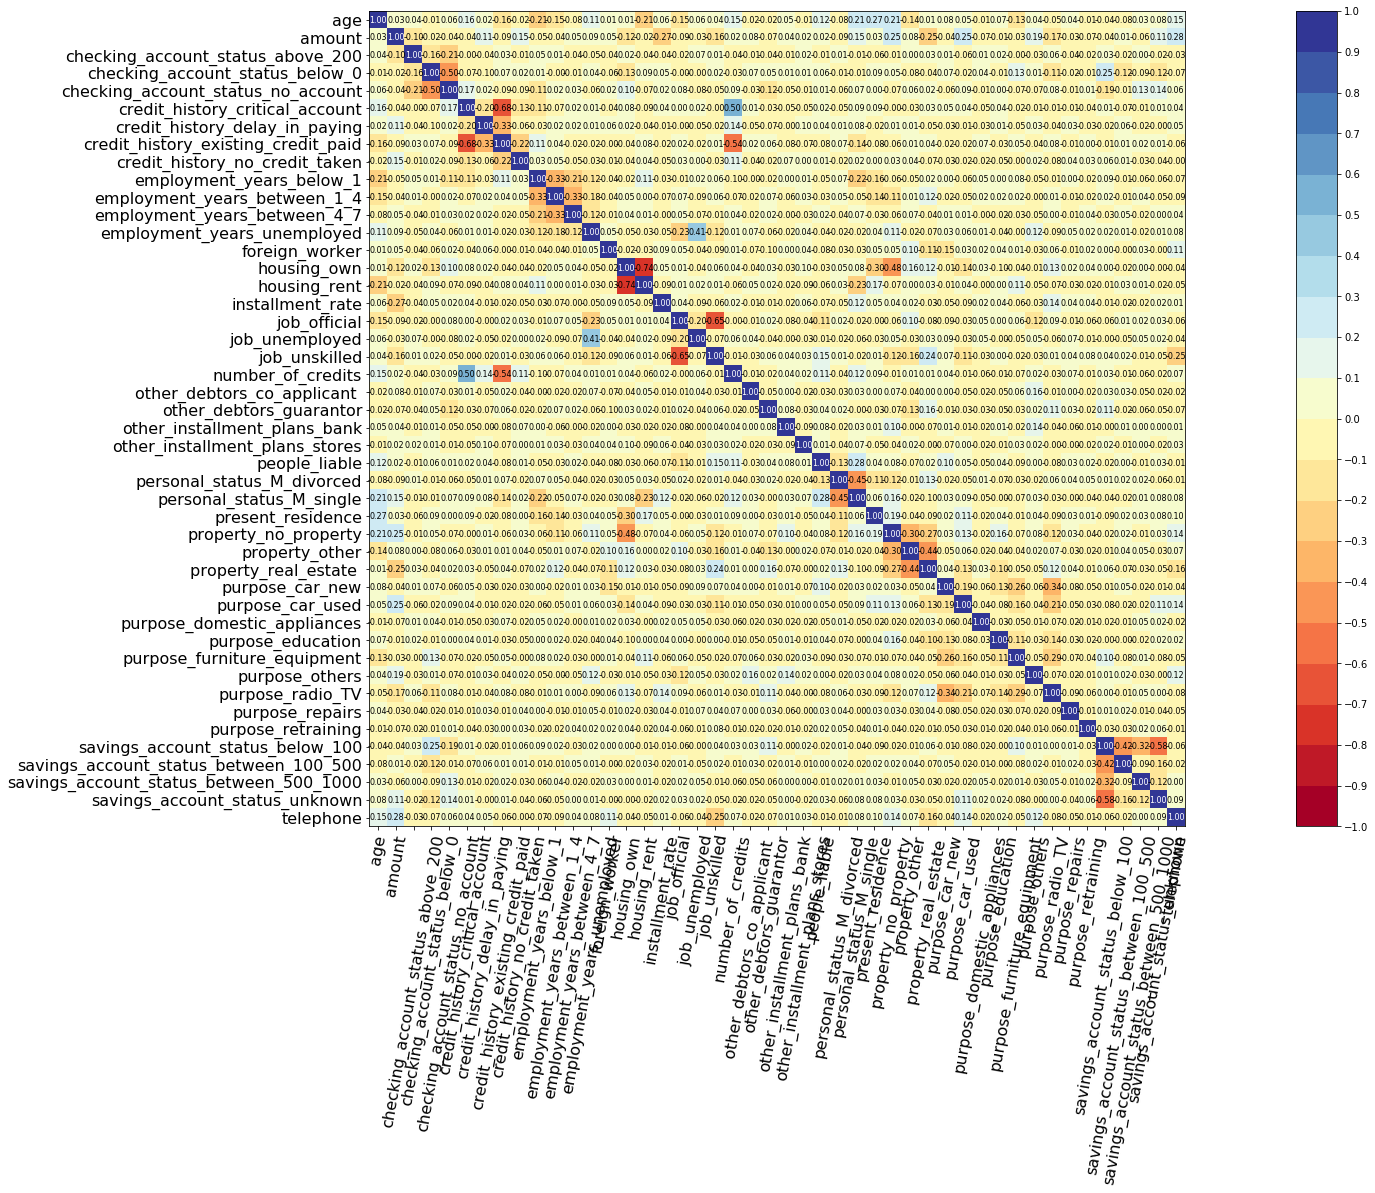

In [4]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(dataset[features], figure_size=(40,15), text_fontsize=8)

Based on the correlations chart, we should remove the following features
* `credit_history_existing_credit_paid`
* `housing_own`

In [5]:
to_remove = ['credit_history_existing_credit_paid', 'housing_own']
features = np.setdiff1d(features, to_remove).tolist()

## 4 - Modeling
So as to perform cross-validation later on and assess the performances of the model, let's split the dataset into training and testing sets.

In [6]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.4)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

Let's now fit a Neural MTLR model to the training set.

*Note: The choice of the structure of the neural network was obtained using grid-search hyperparameters selection, not displayed in this tutorial.*

In [7]:
from pysurvival.models.multi_task import NeuralMultiTaskModel

# Initializing the Neural MTLR with a time axis split into 100 intervals
structure = [ 
                {'activation': 'ReLU', 'num_units': 70}, 
                {'activation': 'Swish', 'num_units': 70}, 
            ] 
neural_mtlr = NeuralMultiTaskModel(bins=100, structure=structure)

# Fitting the model
neural_mtlr.fit(X_train, T_train, E_train, 
                init_method = 'orthogonal', optimizer ='rprop', lr = 1e-3, 
                l2_reg = 1e-1,  l2_smooth = 1e-1,
                batch_normalization = True,  bn_and_dropout = True,
                dropout=0.6,  num_epochs = 500)

% Completion: 100%|**********************************************|Loss: 1259.78


NeuralMultiTaskModel( Layer(1): activation = ReLU, units = 70 ; 
                      Layer(2): activation = Swish, units = 70 )

We can take a look at the values of N-MTLR loss function to ensure that the fitting isn't incomplete

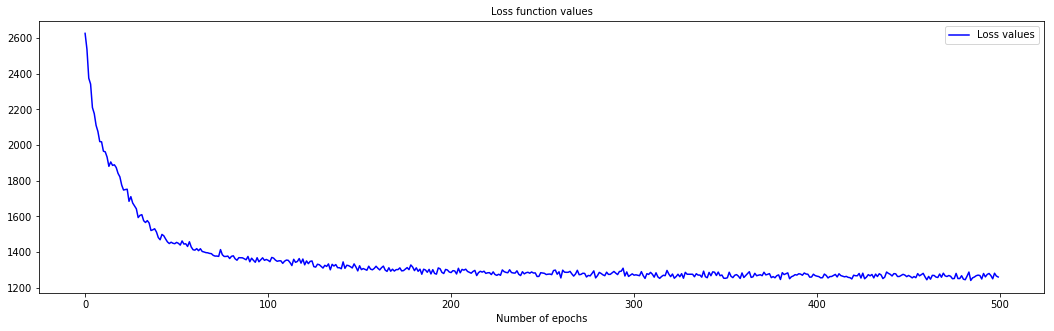

In [8]:
from pysurvival.utils.display import display_loss_values
display_loss_values(neural_mtlr)

---

## 5 - Cross Validation
In order to assess the model performance, we previously split the original dataset into training and testing sets, so that we can now compute its performance metrics on the testing set:

### 5.1 - C-index
The C-index represents the global assessment of the model discrimination power: this is the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores. In general, when the C-index is close to 1, the model has an almost perfect discriminatory power; but if it is close to 0.5, it has no ability to discriminate between low and high risk subjects.

In [9]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(neural_mtlr, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) #0.70

C-index: 0.70


### 5.2 - Brier Score
The Brier score measures the average discrepancies between the status and the estimated probabilities at a given time. Thus, the lower the score (usually below 0.25), the better the predictive performance. To assess the overall error measure across multiple time points, the Integrated Brier Score (IBS) is usually computed as well.

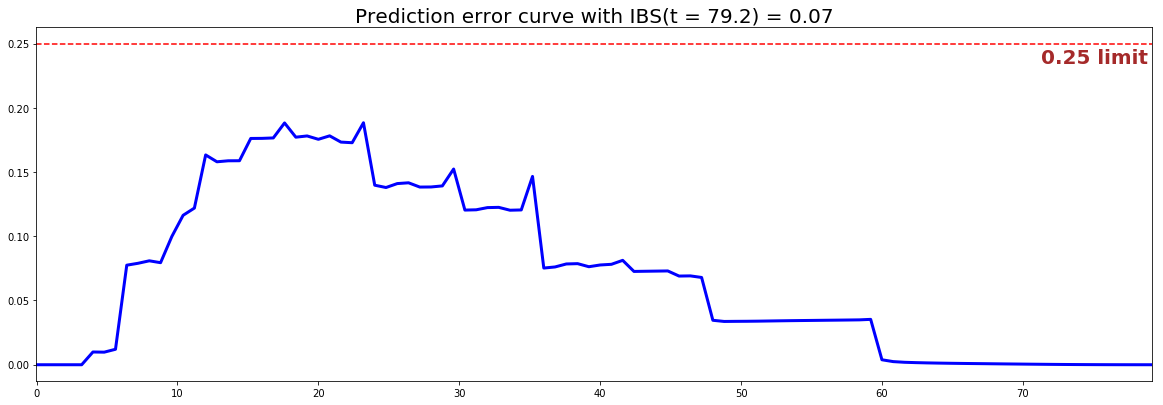

IBS: 0.07


In [10]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(neural_mtlr, X_test, T_test, E_test, t_max=100, 
                       figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs)) #0.07

The IBS is equal to 0.07 on the entire model time axis. This indicates that the model will have good predictive abilities.


---

## 6 - Predictions

### 6.1 - Overall predictions
Now that we have built a model that seems to provide great performances, let's compare the following:

* the time series of the actual and predicted number of loans that were fully repaid, for each time t.

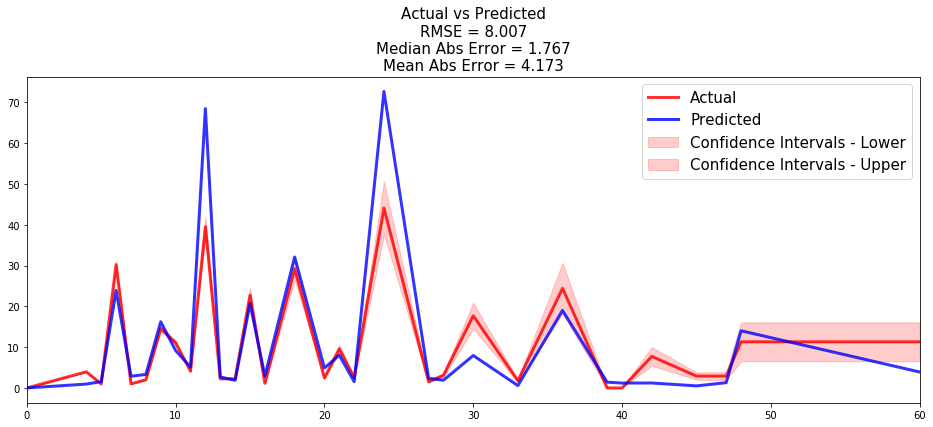

In [11]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(neural_mtlr, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

* the time series of the actual and predicted number of loans that were still active, for each time t.


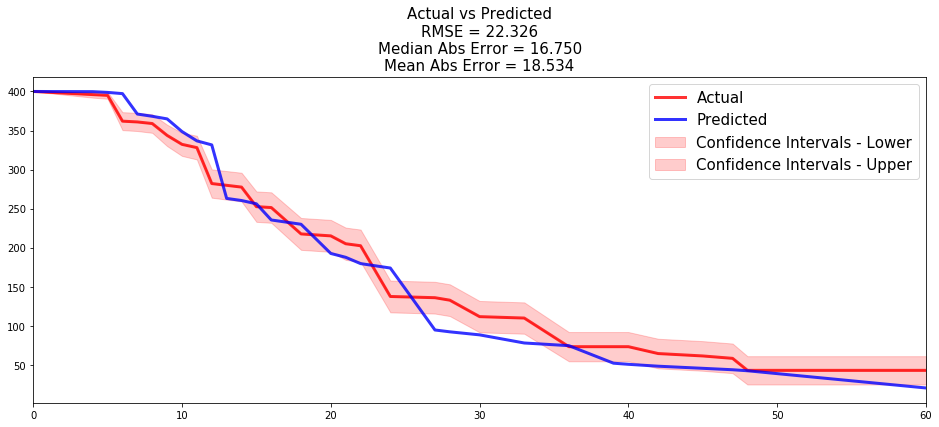

In [12]:
results = compare_to_actual(neural_mtlr, X_test, T_test, E_test,
                            is_at_risk = True,  figure_size=(16, 6), 
                            metrics = ['rmse', 'mean', 'median'])

Both comparisons show that the model do a great job predicting the number of loans that were fully repaid (*average absolute error of 4.5 loan*) or that were still active (*average absolute error of 18.4 loans*) for all times t of the 70+ months time window.

---

### 6.2 - Individual predictions
Now that we know that we can provide reliable predictions for an entire cohort, let's compute the speed of repayment at the individual level. The speed of repayment is given by $\text{Speed}(t) = 1−\text{Survival}(t)$

First, we can construct the risk groups based on risk scores distribution. The helper function `create_risk_groups`, which can be found in `pysurvival.utils.display`, will help us do that:

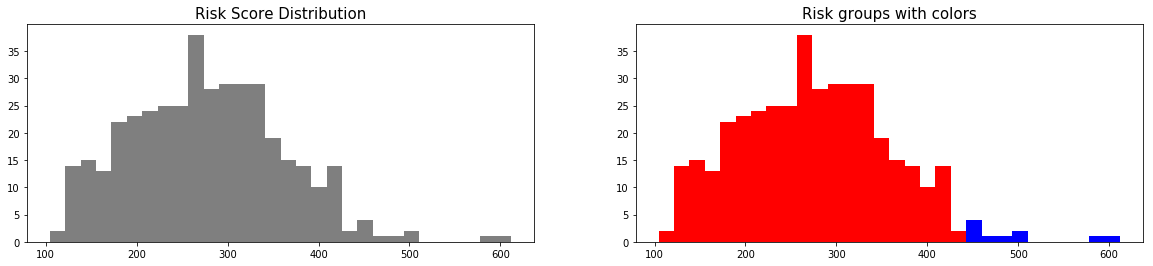

In [13]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=neural_mtlr, X=X_test,
    use_log = False, num_bins=30, figure_size=(20, 4),
    low= {'lower_bound':0, 'upper_bound':430, 'color':'red'},
    high= {'lower_bound':430, 'upper_bound':800, 'color':'blue'}
    )

Here, it is possible to distinguish 2 main groups, *low* and *high* risk groups. Because the C-index is high, the model will be able to perfectly rank the survival times of a random unit of each group, such that $t_{high} \leq t_{low}$.

Let's randomly select individual unit in each group and compare their speed of repayment functions. To demonstrate our point, we will purposely select units which experienced an event to visualize the actual time of event.

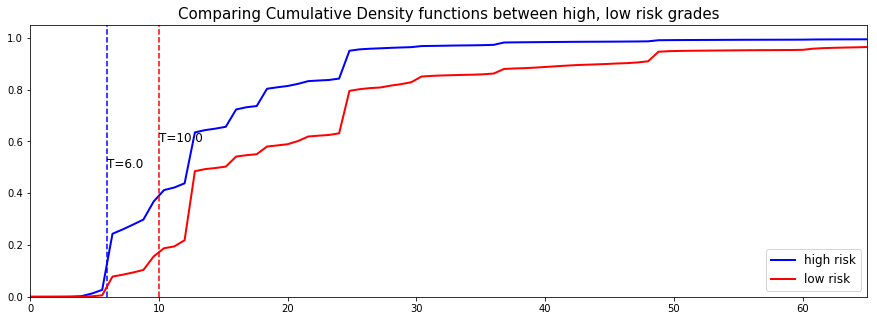

In [14]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Selecting a random individual that experienced an event from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]
    
    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    cdf = 1. - neural_mtlr.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(neural_mtlr.times, cdf, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)), 
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Cumulative Density functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.xlim(0, 65)
plt.ylim(0, 1.05)
plt.show()

---

## 7 - Conclusion
We can now save our model so as to put it in production and score future borrowers.
Thanks to Survival Analysis, we can see that it is indeed possible to predict the speed of repayment of loans and forecast the number of loans that will be fully repaid throughout time, which is a great advantage over classification modeling.

In [15]:
# Let's now save our model
from pysurvival.utils import save_model
save_model(neural_mtlr, '/Users/xxx/Desktop/credit_neural_mtlr.zip')

Saving the model to disk as /Users/xxx/Desktop/credit_neural_mtlr.zip
